## **ICR - Identifying Age-Related Conditions Dataset** 

Questions I have for the group: 

1. What should we do with the features that have lots of nulls? ('BQ' and 'EL'): imputing
2. How do we choose how many folds? Akabane et al.  mentions 5, Mythili et al. mentions 10, Kaggle notebook mentions 5: "golden standard is 10" (async)
3. When we split data, columns become objects. Maybe delete the non-numeric one? Yes, that worked. Do we want to include it? Is there a work-around?

In [2]:
# Akabane et al. test/train split
akabane_train = (6564/8792)*100
akabane_test = (2228/8792)*100

print(f"Akabane et al train: {akabane_train:.0f}%, test: {akabane_test:.0f}%")
print("Alageel et al train: 80%, test: 20%")
print("Alageel et al train: 80%, test: 20%")

Akabane et al train: 75%, test: 25%
Alageel et al train: 80%, test: 20%
Alageel et al train: 80%, test: 20%


#### ``Objectives``

#### ``Motivation``

#### ``Data``

### Step 1: Import libraries

In [3]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os


from sklearn.model_selection import KFold
from mlxtend.plotting import heatmap
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

2023-06-25 19:57:51.979853: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Step 2: Define functions

### Step 3: Read data

In [4]:
#set working directory
os.chdir('/Users/ecompu/Library/CloudStorage/OneDrive-Personal/Berkeley/W207_Machine_Learning/mids-207-final-project-summer23-Burzon-Brown-Caldera-Gomez/icr-identify-age-related-conditions/')

dataset_df = pd.read_csv('train.csv')
print("Full dataset shape is {}".format(dataset_df.shape)) 

Full dataset shape is (617, 58)


In [23]:
dataset_df.head()


,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [21]:
greeks_df = pd.read_csv('greeks.csv')
greeks_df.head()


,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020


In [24]:
# merge greeks and dataset

all_vars = dataset_df.merge(greeks_df, left_on='Id', right_on='Id')
all_vars.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GF,GH,GI,GL,Class,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,2003.810319,22.136229,69.834944,0.120343,1,B,C,G,D,3/19/2019
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,27981.562750,29.135430,32.131996,21.978000,0,A,C,M,B,Unknown
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,13676.957810,28.022851,35.192676,0.196941,0,A,C,M,B,Unknown
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,2094.262452,39.948656,90.493248,0.155829,0,A,C,M,B,Unknown
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8524.370502,45.381316,36.262628,0.096614,1,D,B,F,B,3/25/2020


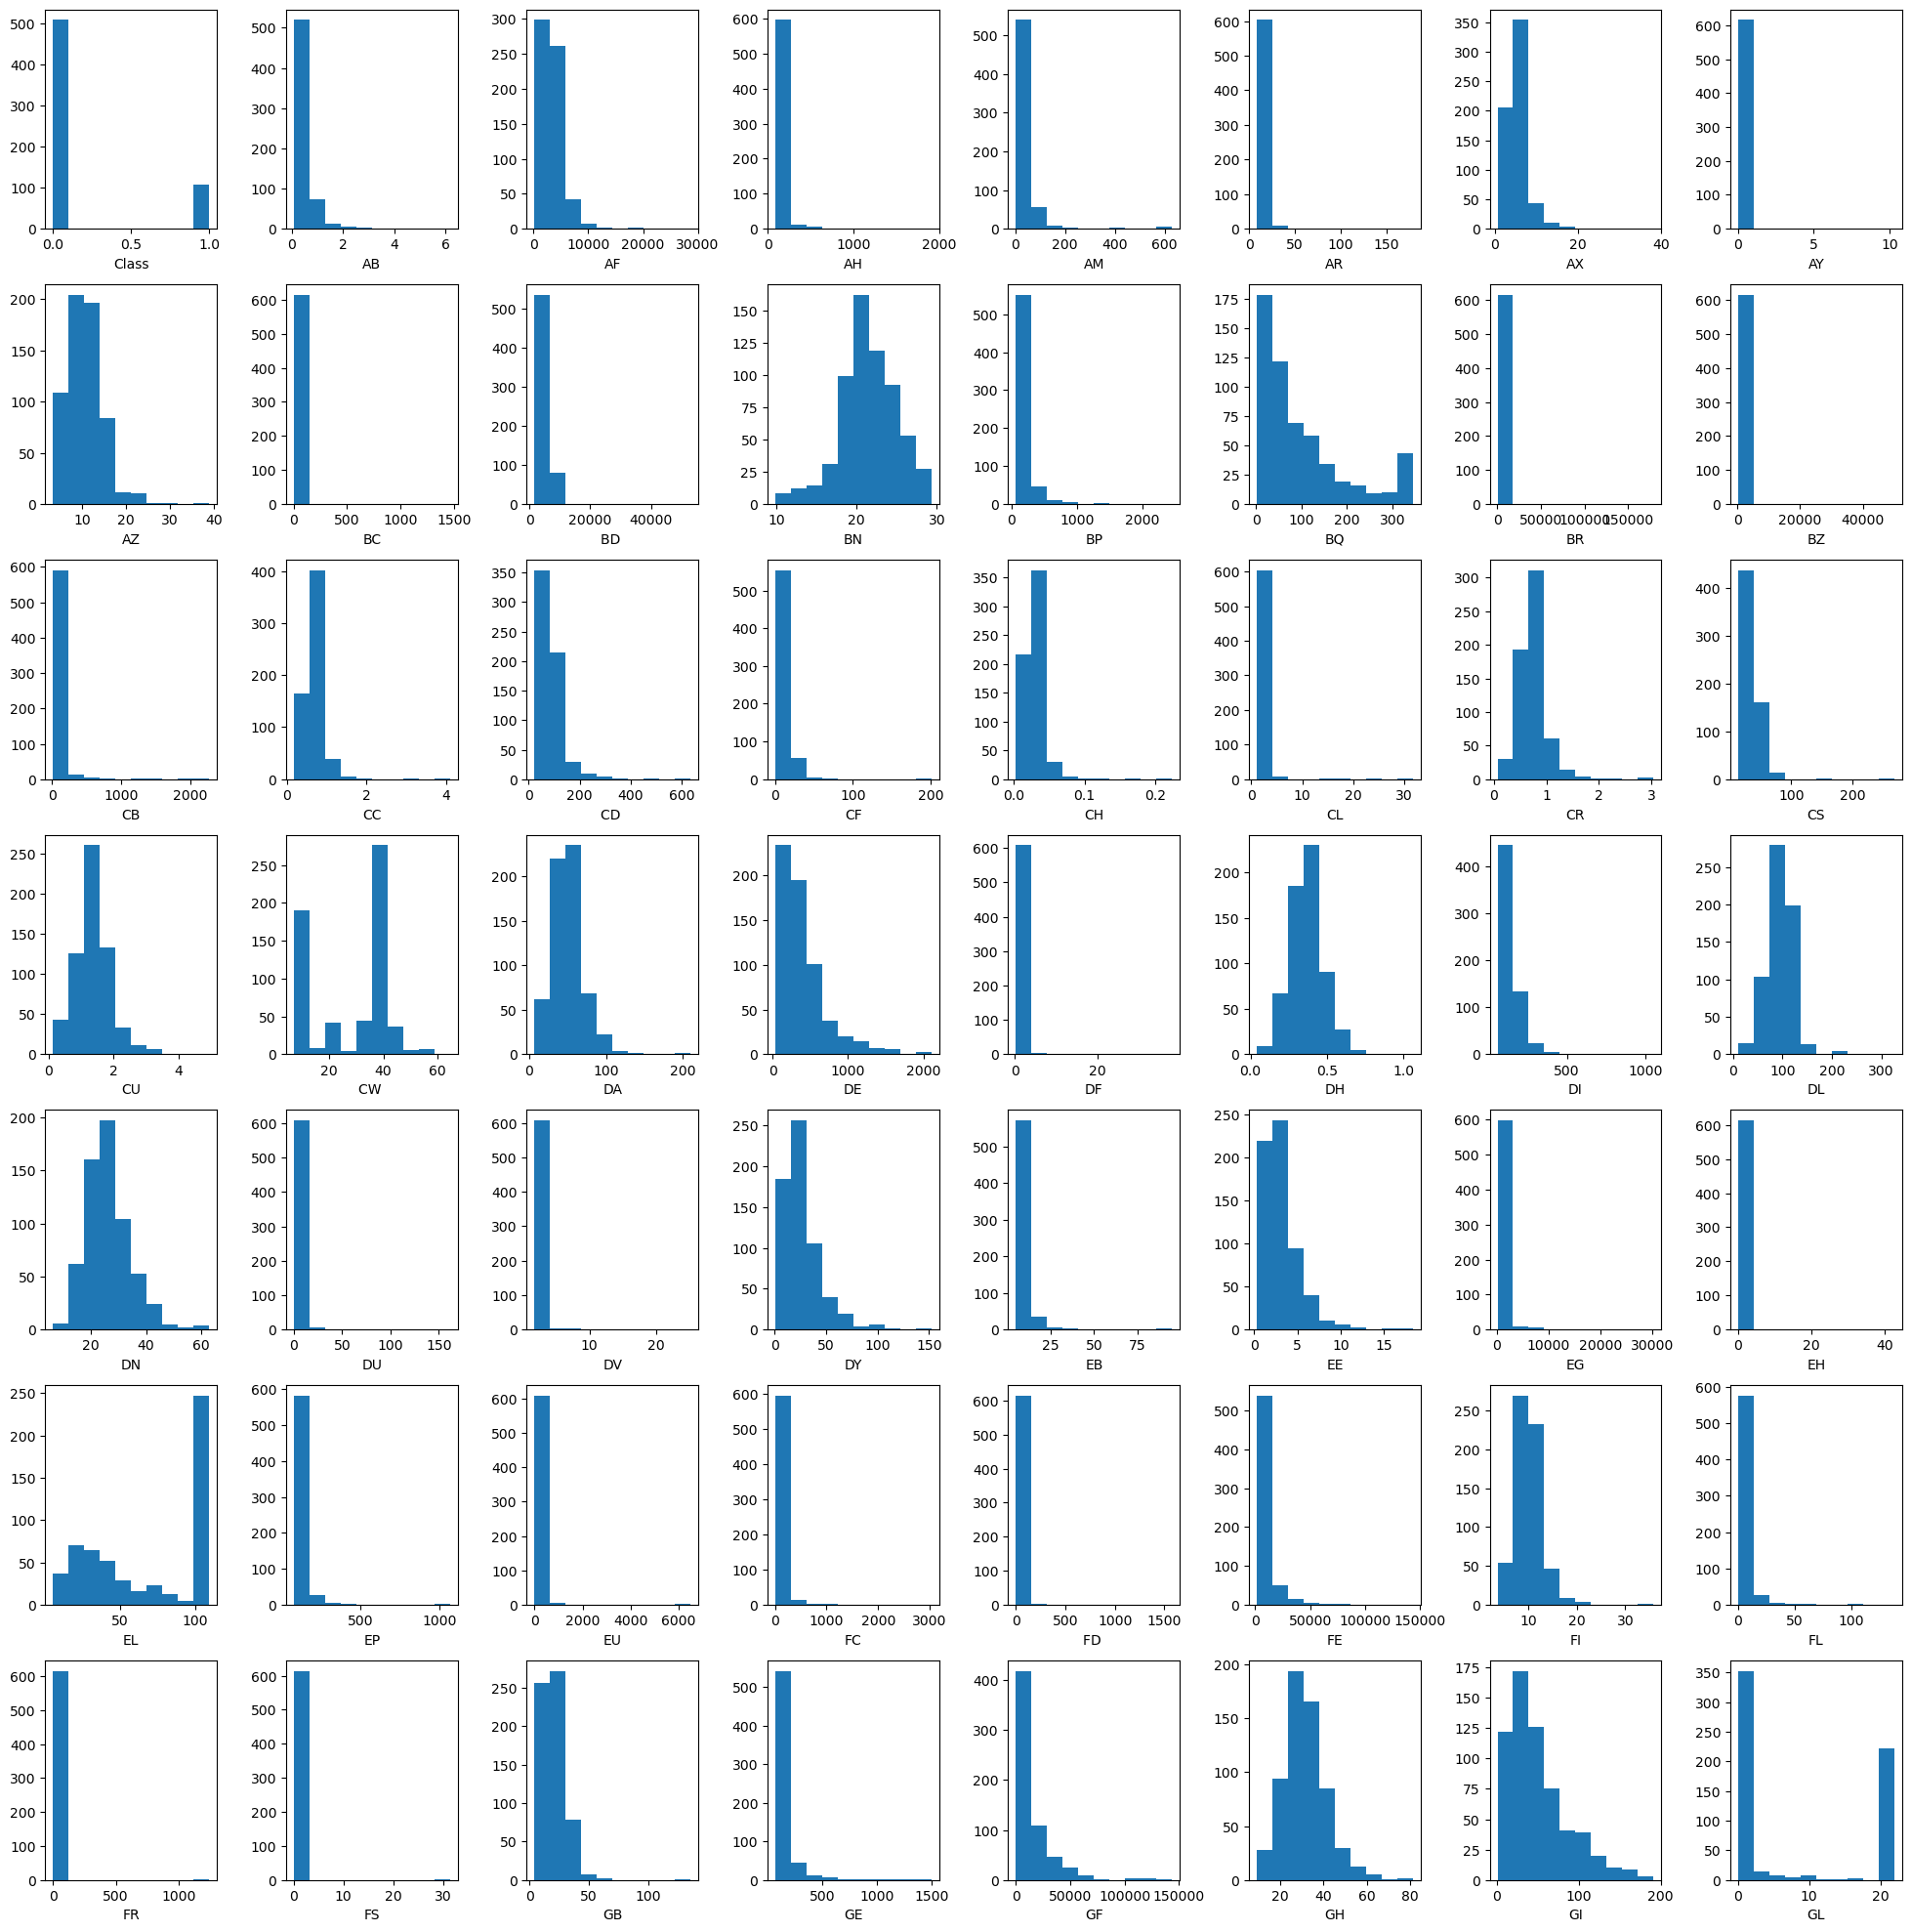

In [30]:
final_vars = ['Class', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Beta','Gamma','Delta','Epsilon']
columns = final_vars
fig, axes = plt.subplots(nrows=7, ncols=8, figsize=(20,20))
fig.tight_layout(pad=2.0)
for idx, ax in enumerate(axes.flatten()):
    ax.hist(all_vars[columns[idx]])
    ax.set_xlabel(columns[idx])

### Step 4: Preprocess data

In [25]:
# check column names. Drop Alpha because its also the class 
all_vars.columns

Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class', 'Alpha',
       'Beta', 'Gamma', 'Delta', 'Epsilon'],
      dtype='object')

In [22]:
all_vars.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


``split data into training and test``

In [6]:
# define outcome #
##################
y = dataset_df['Class'].values

# define features #
###################
columns = [i for i in dataset_df.columns if i not in ["Id", "EJ",'Class']]

X = dataset_df[columns].values

# split #
#########
split = (0.7,0.3) #70% training and 30% test: CHECK PAPERS
shuffle = np.random.permutation(np.arange(y.shape[0])) 
X, y = X[shuffle], y[shuffle]

splits = np.multiply(len(y), split).astype(int) 
X_train, X_test = np.split(X, [splits[0]])
y_train, y_test = np.split(y, [splits[0]])


# df for y_train and X_train #
##############################
# easier for EDA later on
df_train = pd.concat(
    [pd.DataFrame(y_train), pd.DataFrame(X_train)],
    axis=1
)

# rename columns
df_train.columns=['Class', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']

### Step 5: EDA


1. Columns: 1 Class column (0/1) and 55 features (we dropped the only non-numeric one: EJ)
2. Check data types: Features are objects, Label 'Class' is int64
3. Count number of nulls per feature: 'BQ' and 'EL' have the largest number of nulls (48 and 48, respectively). Other features with nulls are: 'CC','FS','FC'
4. Check for duplicates: 
5. Summary statistics: The distributions of the features vary, so we would probably benefit from standarization. 
6. Histogram of variables: The labels show class imbalance. 


In [7]:
# Look at the dataset
df_train.head()

,Class,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,0,0.363205,1724.10480,99.944484,13.818814,8.138688,4.987617,0.025578,11.060010,6.121388,...,8.363221,0.173229,1.48712,0.081276,18.138900,72.611063,55497.521950,27.133532,23.284316,21.978
1,0,0.666588,2574.12012,101.651448,24.714060,14.216484,8.354037,0.105357,9.654664,1.229900,...,14.333800,0.173229,1.47755,0.067730,28.845502,1497.351958,14473.780330,25.261869,164.309648,21.978
2,0,0.247834,2267.05116,85.200147,14.884182,8.138688,6.369621,0.025578,14.727774,1.229900,...,11.329215,0.173229,1.12810,0.067730,22.696880,72.611063,43395.398780,38.010015,39.180562,21.978
3,0,1.491277,2434.32640,137.149332,124.242349,8.138688,4.730706,0.025578,4.487024,1.229900,...,4.917596,9.126892,2.44238,0.067730,30.919848,72.611063,819.350802,20.156657,31.537864,0.027
4,0,0.247834,5021.27010,101.137617,35.785835,8.138688,4.952181,0.052374,11.236466,6.430620,...,3.583450,0.173229,1.30674,0.067730,22.101552,72.611063,24430.832660,28.882402,58.489852,21.978


In [8]:
# Check datatypes for each column
df_train.dtypes

Class      int64
AB       float64
AF       float64
AH       float64
AM       float64
AR       float64
AX       float64
AY       float64
AZ       float64
BC       float64
BD       float64
BN       float64
BP       float64
BQ       float64
BR       float64
BZ       float64
CB       float64
CC       float64
CD       float64
CF       float64
CH       float64
CL       float64
CR       float64
CS       float64
CU       float64
CW       float64
DA       float64
DE       float64
DF       float64
DH       float64
DI       float64
DL       float64
DN       float64
DU       float64
DV       float64
DY       float64
EB       float64
EE       float64
EG       float64
EH       float64
EL       float64
EP       float64
EU       float64
FC       float64
FD       float64
FE       float64
FI       float64
FL       float64
FR       float64
FS       float64
GB       float64
GE       float64
GF       float64
GH       float64
GI       float64
GL       float64
dtype: object

In [9]:
# Find which columns have missing values 
sum_null = df_train.isnull().sum()
sum_null[sum_null!=0]

BQ    48
CB     1
CC     2
DU     1
EL    45
FC     1
FL     1
FS     2
GL     1
dtype: int64

In [10]:
# Check whether we have duplicated data: no 
df_train.duplicated().sum()


0

In [11]:
# summary statistics for the numeric columns 
df_train.describe()

,Class,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
count,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,...,431.000000,430.000000,431.000000,429.000000,431.000000,431.000000,431.000000,431.000000,431.000000,430.000000
mean,0.178654,0.456819,3493.736833,115.459527,35.636065,9.905673,5.537173,0.067581,10.542844,6.074385,...,10.176154,5.594607,4.397985,0.372247,20.590150,138.488620,15128.723150,31.347906,50.731414,8.464194
std,0.383508,0.420019,2505.908611,103.665204,58.119251,9.101783,2.689122,0.497451,4.321048,33.182597,...,3.001131,12.158162,60.002144,0.373919,9.023550,161.357728,19674.556395,9.791479,36.270358,10.340265
min,0.000000,0.085460,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,...,3.583450,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,2.821484,0.001129
25%,0.000000,0.247834,2073.089975,85.200147,11.957517,8.138688,4.150441,0.025578,8.179996,1.229900,...,8.512072,0.173229,0.497060,0.067730,13.939047,72.611063,2770.846988,25.113029,22.754484,0.121856
50%,0.000000,0.346113,3042.160220,85.200147,20.065463,8.138688,5.023053,0.025578,10.347884,1.229900,...,9.973017,3.067779,1.129260,0.257374,18.771436,72.611063,7902.173376,30.432198,42.291396,0.325541
75%,0.000000,0.538398,4381.319250,112.385290,35.781189,8.138688,6.489218,0.038367,12.837174,5.056646,...,11.522170,6.150698,1.501620,0.555386,25.664218,132.524355,20700.419740,36.235098,68.798428,21.978000
max,1.000000,6.161666,28688.187660,1817.620554,630.518230,178.943634,38.270880,10.315851,38.971568,643.553960,...,35.851039,137.932739,1244.227020,2.614378,62.667574,1497.351958,143790.071200,81.210825,191.194764,21.978000


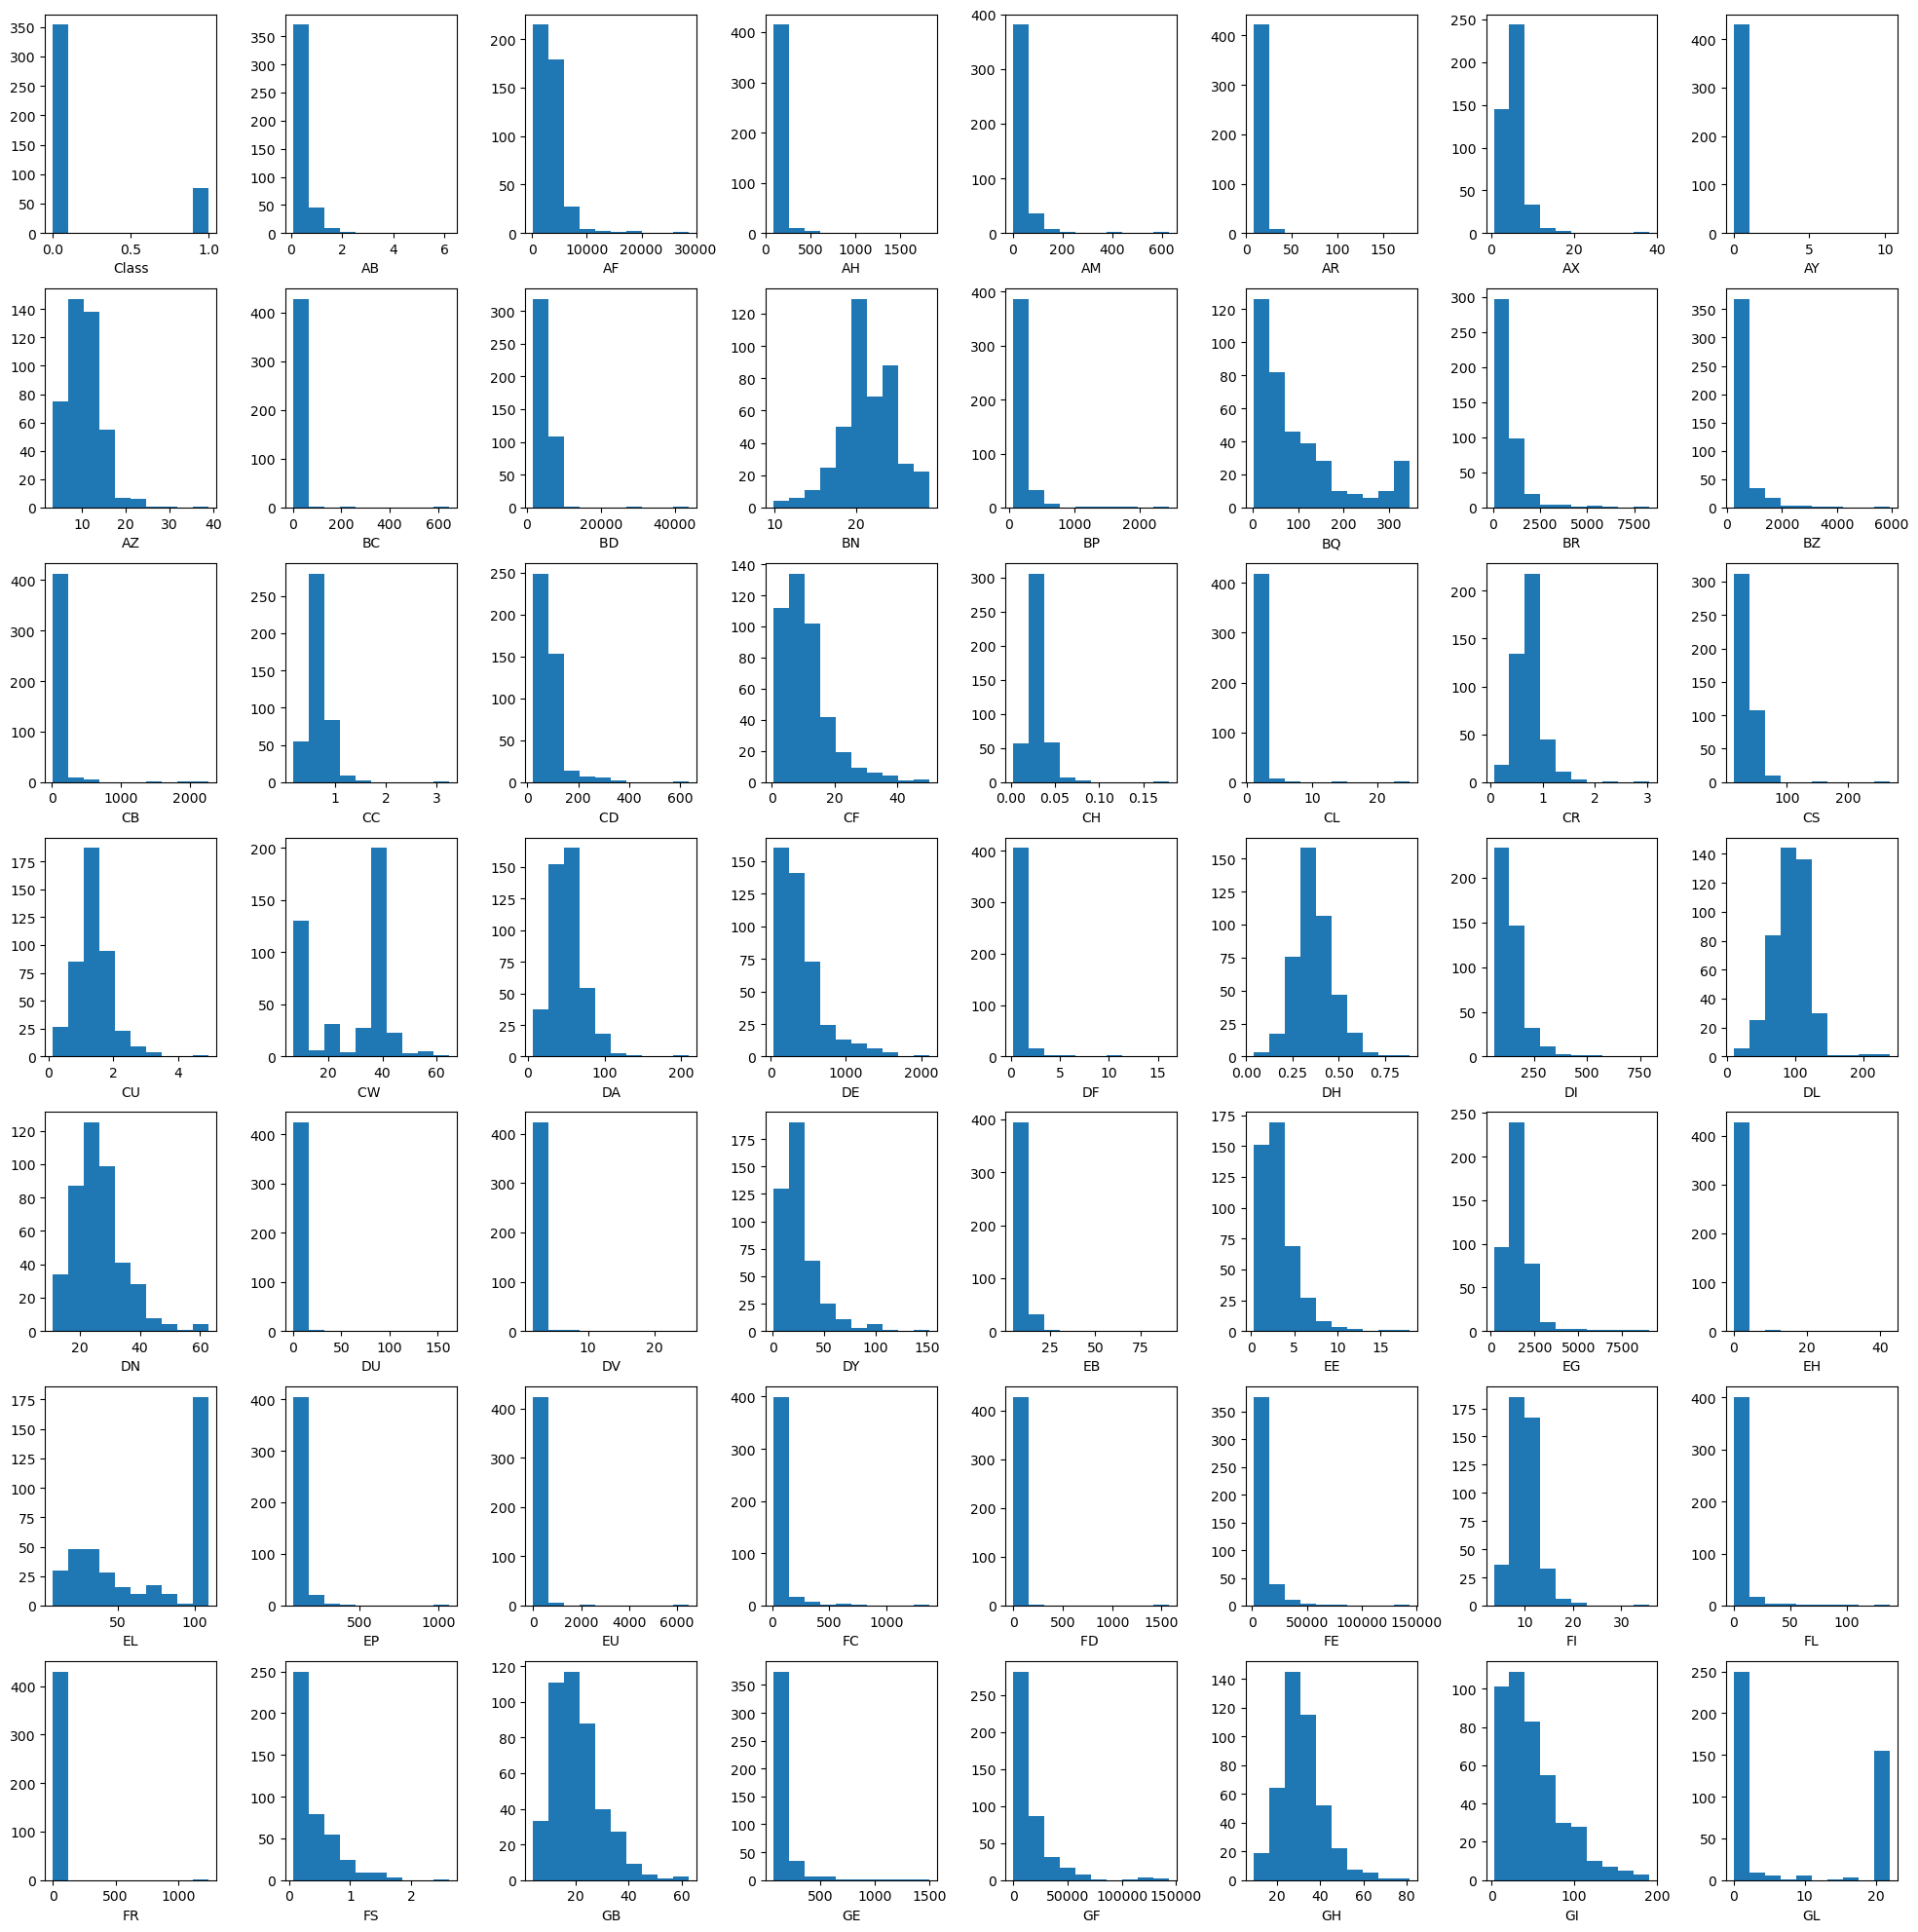

In [12]:
#check distributions of features and labels
columns = [i for i in df_train.columns]
fig, axes = plt.subplots(nrows=7, ncols=8, figsize=(20,20))
fig.tight_layout(pad=2.0)
for idx, ax in enumerate(axes.flatten()):
    ax.hist(df_train[columns[idx]])
    ax.set_xlabel(columns[idx])

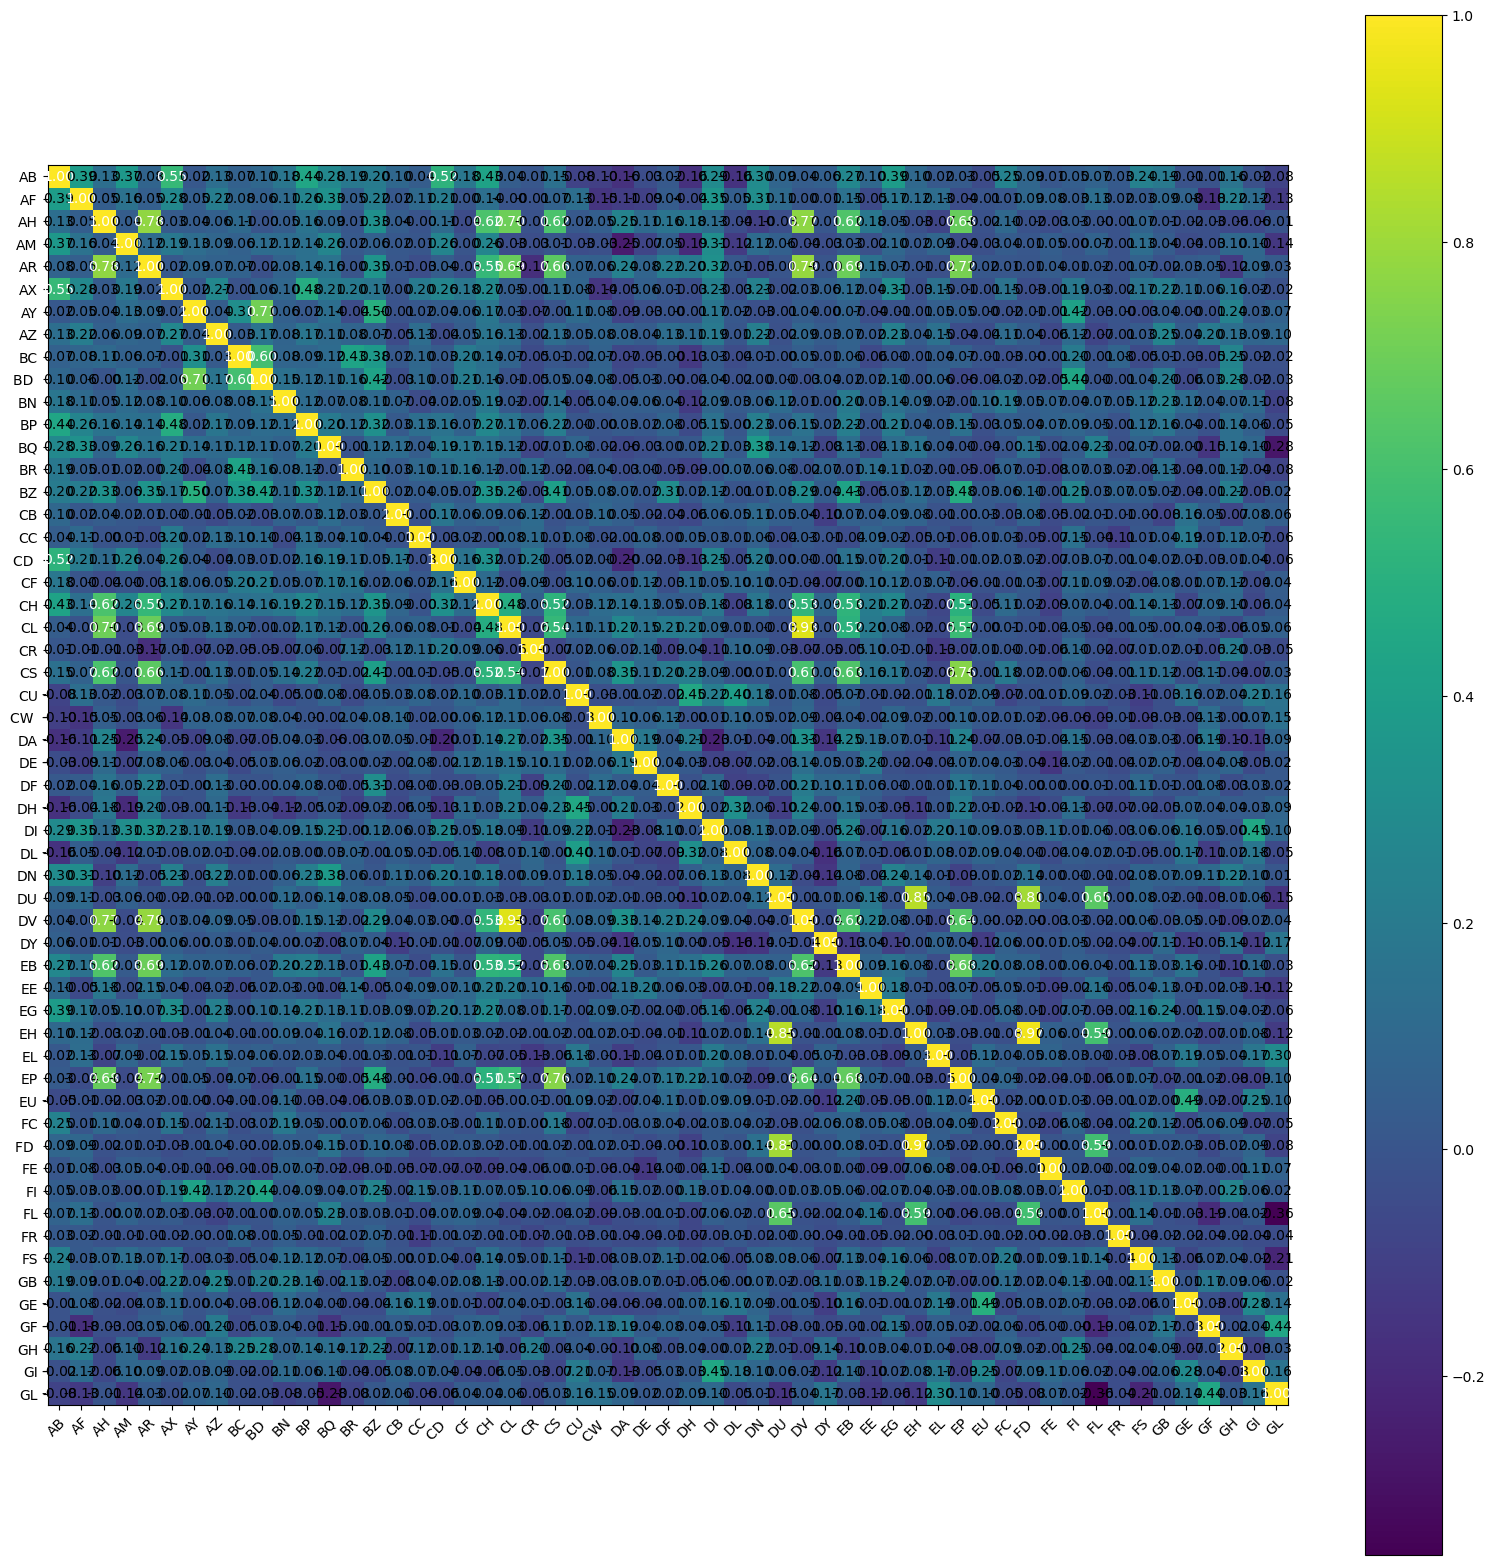

In [20]:
# bivariate interactions

FEATURE_COLUMNS = [i for i in df_train.columns if i not in ["Class"]]
feature_train_df = df_train[FEATURE_COLUMNS]

cm = feature_train_df.corr().values
hm = heatmap(
    cm,
    row_names=feature_train_df.columns,
    column_names=feature_train_df.columns,
    figsize=(20, 20)
)

### Step 6: Learning Model

### Step 7: Evaluation

### Conclusions